# Extracting resonance information using Resonance Finder

When looking for long-lived resonances using FDTD simulation, the total time to fully decay fields within the simulation domain can be extremely long. In this situation, the [Resonance Finder](../api/_autosummary/tidy3d.plugins.resonance.ResonanceFinder.html#tidy3d.plugins.resonance.ResonanceFinder.html) plugin allows one to find resonances and extract their information from time domain field monitors without the necessity of waiting for the fields to completely decay. The resonance information consisting of frequency $f$, decay rate $\alpha$, Q-factor, amplitude $a$, and phase $\phi$ is obtained from a time series of the form:

$f(t) = \sum_{k}a_{k}e^{i\phi_{k}}e^{-2\pi if_{k}t-\alpha_{k}t}$,

where $k$ is the frequency of interest index. The resonance finder algorithm was derived from `V. A. Mandelshtam, and H. S. Taylor, "Harmonic inversion of time signals and its applications," J. Chem. Phys. 107(17), 6756–6769 (1997)` [DOI: 10.1063/1.475324](https://doi.org/10.1063/1.475324). This notebook illustrates the tool usage through the example of a simple photonic cavity. More examples on using the resonance finder in different applications are available in [Optimized photonic crystal L3 cavity](https://www.flexcompute.com/tidy3d/examples/notebooks/OptimizedL3/), [Band structure calculation of a photonic crystal slab](https://www.flexcompute.com/tidy3d/examples/notebooks/Bandstructure/), or [Bistability in photonic crystal microcavities](https://www.flexcompute.com/tidy3d/examples/notebooks/BistablePCCavity/) notebooks. 

If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/tidy3d/learning-center/fdtd101/) tutorials. FDTD simulations can diverge due to various reasons. If you run into any simulation divergence issues, please follow the steps outlined in our [troubleshooting guide](https://www.flexcompute.com/tidy3d/examples/notebooks/DivergedFDTDSimulation/) to resolve it.

To start, we need to import the Tidy3D resonance finder plugin as below:

In [1]:
# Standard python imports.
import numpy as np
import matplotlib.pyplot as plt

# Tidy3D imports.
import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins.resonance import ResonanceFinder

## Microdisk Cavity Set Up
To illustrate the resonance finder usage, we will define a simple GaAs microdisk cavity.

In [2]:
# Simulation wavelength
wl_min = 1.9
wl_max = 2.0
n_wl = 101
wl_c = (wl_min + wl_max) / 2
wl_range = np.linspace(wl_min, wl_max, n_wl)
freq_c = td.C_0 / wl_c
freq_range = td.C_0 / wl_range
freq_bw = 0.5 * (freq_range[0] - freq_range[-1])

# Simulation runtime
runtime_fwidth = 20  # In units of 1/frequency bandwidth of the source.
t_start_fwidth = 2  # Time to start monitoring after source has decayed, units of 1/frequency bandwidth.
run_time = runtime_fwidth / freq_bw
t_start = t_start_fwidth / freq_bw
print(f"Total runtime = {(run_time*1e12):.2f} ps")
print(f"Start monitoring fields after {(t_start*1e12):.2f} ps")

# Microdisk geometry
r = 2.60
t = 0.16

# Microdisk material
n = 3.50
mat_disk = td.Medium(permittivity=n ** 2)

Total runtime = 5.07 ps
Start monitoring fields after 0.51 ps


The microdisk structure is obtained using a simple cylinder.

In [3]:
# Simulation size.
pml_gap = 0.6 * wl_max
size_x = 2 * (r + pml_gap)
size_y = size_x
size_z = t + 2 * pml_gap

# Microdisk.
microdisk = td.Structure(
    geometry=td.Cylinder(center=(0, 0, 0), radius=r, length=t, axis=2),
    medium=mat_disk,
)

We will use several point dipole sources randomly distributed within a squared region bounded by the microdisk to excite the cavity modes. Reproducibility between simulation runs is ensured by seeding the random generator. We limit the dipole polarizations to only one direction as we will include 8-fold symmetry.

In [4]:
num_dipoles = 7
rng = np.random.default_rng(4321)

# Squared region within microdisk.
side_x = r * np.cos(45 * np.pi / 180)
side_y = r * np.cos(45 * np.pi / 180)

# Build random positions and phases to dipoles.
dip_positions = rng.uniform([0, 0, 0], [side_x, side_y, 0], [num_dipoles, 3])
dip_phases = rng.uniform(0, 2 * np.pi, num_dipoles)

# Dipoles
pulses = []
dipoles = []
for i in range(num_dipoles):
    pulse = td.GaussianPulse(freq0=freq_c, fwidth=freq_bw, phase=dip_phases[i])
    pulses.append(pulse)
    dipoles.append(
        td.PointDipole(
            source_time=pulse,
            center=tuple(dip_positions[i]),
            polarization="Ey",
            name="dip_source_" + str(i),
        )
    )

The [Resonance Finder](../api/_autosummary/tidy3d.plugins.resonance.ResonanceFinder.html#tidy3d.plugins.resonance.ResonanceFinder.html) plugin needs `FieldTimeMonitors` to record the field as a function of time. So, we will include them at several random locations. Importantly, we start the monitors after the source pulse has decayed.

In [5]:
num_monitors = 7

# Random monitor positions.
mon_positions = rng.uniform([0, 0, 0], [side_x, side_y, 0], [num_dipoles, 3])

# Monitor list.
monitors_time = []
for i in range(num_monitors):
    monitors_time.append(
        td.FieldTimeMonitor(
            fields=["Ey"],
            center=tuple(mon_positions[i]),
            size=(0, 0, 0),
            start=t_start,
            name="monitor_time_" + str(i),
        )
    )

## Microdisk Cavity Simulation

Now, we can build and run the simulation. It is worth mentioning that we will run the simulation for a shorter `run_time` period, thus not waiting a very long time for the fields to decay fully.

In [6]:
sim = td.Simulation(
    center=(0, 0, 0),
    size=(size_x, size_y, size_z),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=wl_c),
    structures=[microdisk],
    sources=dipoles,
    monitors=monitors_time,
    run_time=run_time,
    shutoff=0,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    normalize_index=None,
    symmetry=(1, -1, 1),
)

sim.plot_3d(width=400, height=400)

Before running the simulation, let's look at the source and monitor positions and certify we are measuring the fields after the sources have fully decayed.

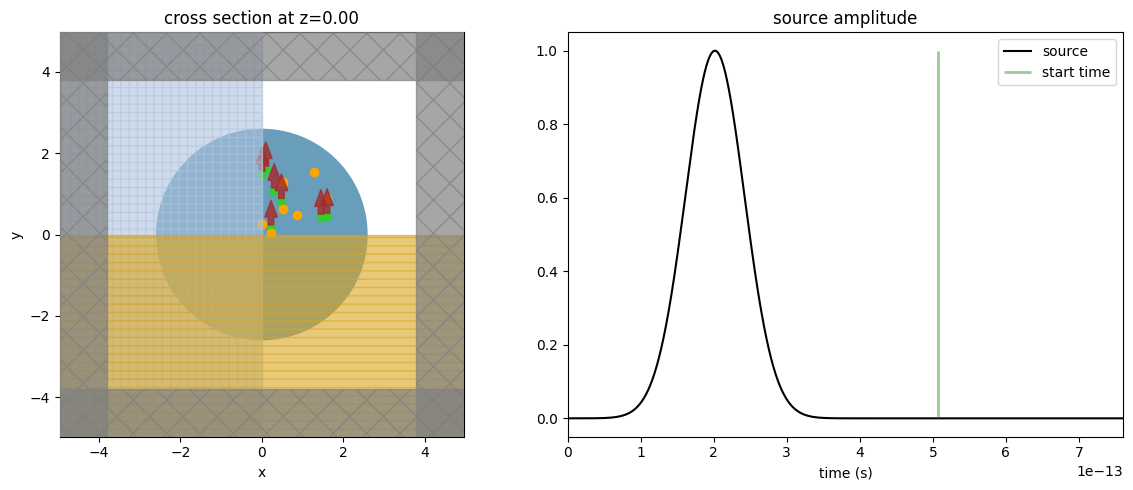

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(12, 5))
sim.plot(z=0.0, ax=ax1)

plot_time = 3 / freq_bw
sim.sources[0].source_time.plot(
    times=np.linspace(0, plot_time, 1001), val="abs", ax=ax2
)
ax2.set_xlim(0, plot_time)
ax2.vlines(t_start, 0, 1, linewidth=2, color="g", alpha=0.4)
ax2.legend(["source", "start time"])
plt.show()

In [8]:
job = web.Job(simulation=sim, task_name="microdisk", verbose=False)
sim_data = job.run(path="data/simulation_data.hdf5")

## Cavity Resonance Information
Now, we can analyze the simulation data and calculate the resonance information from the time domain fields. First, let's look at one of the `FieldTimeMonitors` data. As expected, it is clear from the source signal, and a decaying oscillating pattern due to the cavity resonances is shown.

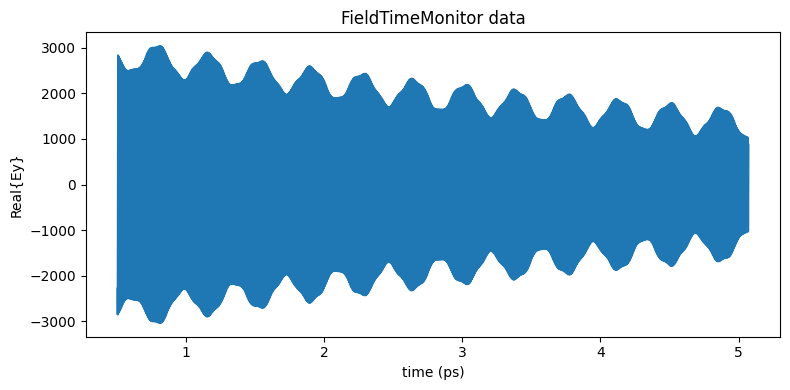

In [9]:
fig, ax1 = plt.subplots(1, 1, tight_layout=True, figsize=(8, 4))

ax1.plot(
    sim_data.monitor_data["monitor_time_0"].Ey.t * 1e12,
    np.real(sim_data.monitor_data["monitor_time_0"].Ey.squeeze()),
)
ax1.set_title("FieldTimeMonitor data")
ax1.set_xlabel("time (ps)")
ax1.set_ylabel("Real{Ey}")
plt.show()

We first construct a `ResonanceFinder` object storing our parameters and then call `run()` on our list of `FieldTimeData` objects. This will add up the signals from all monitors before searching for resonances. Additionally, the `ResonanceFinder` class has the methods [`run_raw_signal`](../api/_autosummary/tidy3d.plugins.resonance.ResonanceFinder.html) and [`run_scalar_field_time`](../api/_autosummary/tidy3d.plugins.resonance.ResonanceFinder.html) which are helpful case the signal takes another form.

The `run()` method returns an `xr.Dataset` containing the decay rate, Q factor, amplitude, phase, and estimation error for each resonance as a function of frequency.

In [10]:
resonance_finder = ResonanceFinder(freq_window=(freq_range[-1], freq_range[0]))
resonance_data = resonance_finder.run(signals=sim_data.data)
resonance_data.to_dataframe()

,decay,Q,amplitude,phase,error
freq,,,,,
1.541813e+14,1.697680e+11,2.853158e+03,910.331148,0.806730,0.003234
1.565147e+14,1.050419e+13,4.681042e+01,345.389469,2.084371,0.041763
1.568775e+14,2.717268e+08,1.813753e+06,389.376832,2.559757,0.002555
1.592080e+14,6.269208e+12,7.978147e+01,208.166494,-2.219305,0.036371


The microdisk cavity has four resonances, two of which have high Q-factors above $10^{3}$ and minor estimation errors. One can use this information to filter out undesired modes. The following graph shows the highest Q-factor resonances as peaks in the Fourier-transformed field data.

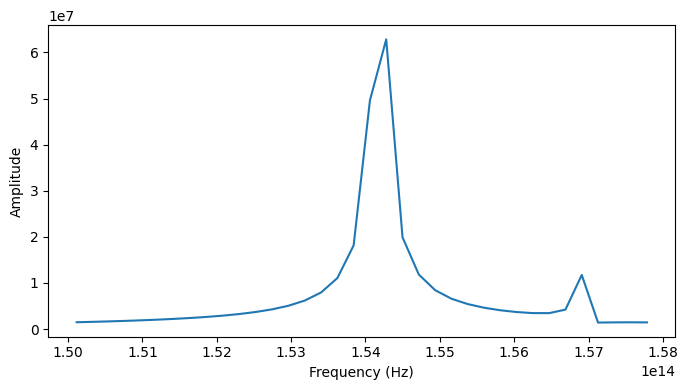

In [11]:
fig, ax1 = plt.subplots(1, 1, tight_layout=True, figsize=(7, 4))

time_response = sim_data["monitor_time_0"].Ey.squeeze()
freq_response = np.abs(np.fft.fft(time_response))
freqs = np.linspace(0, 1/sim_data.simulation.dt, len(time_response))
plot_inds = np.where((freq_range[-1] < freqs) & (freqs < freq_range[0]))
ax1.plot(freqs[plot_inds], freq_response[plot_inds])
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Amplitude")
plt.show()

## Cavity Mode Field

Lastly, we will see the field of the cavity mode field distributions. So, we will rerun the simulation using `FieldMonitors` to get the frequency-domain fields at each cavity resonance. Here, an [Apodization](../api/_autosummary/tidy3d.ApodizationSpec.html) object is employed to exclude the source signal from the Fourier-transformed fields.

In [12]:
# Apodization to exclude the source pulse from the frequency-domain monitors.
apodization = td.ApodizationSpec(start=t_start, width=4e-13)
n_modes = resonance_data["freq"].size

# Field monitor.
mon = [
    td.FieldMonitor(
        center=[0, 0, 0.04],
        size=[td.inf, td.inf, 0],
        freqs=resonance_data["freq"][i],
        name="field_xy_" + str(i),
        apodization=apodization,
    )
    for i in range(n_modes)
]

sim_field = sim.copy(update={"monitors": mon})
job = web.Job(simulation=sim_field, task_name="microdisk_field", verbose=False)
sim_data_field = job.run(path="data/simulation_data.hdf5")

Two high Q-factor whispering-gallery modes are well confined within the microdisk, whereas the others have an intense energy leakage.

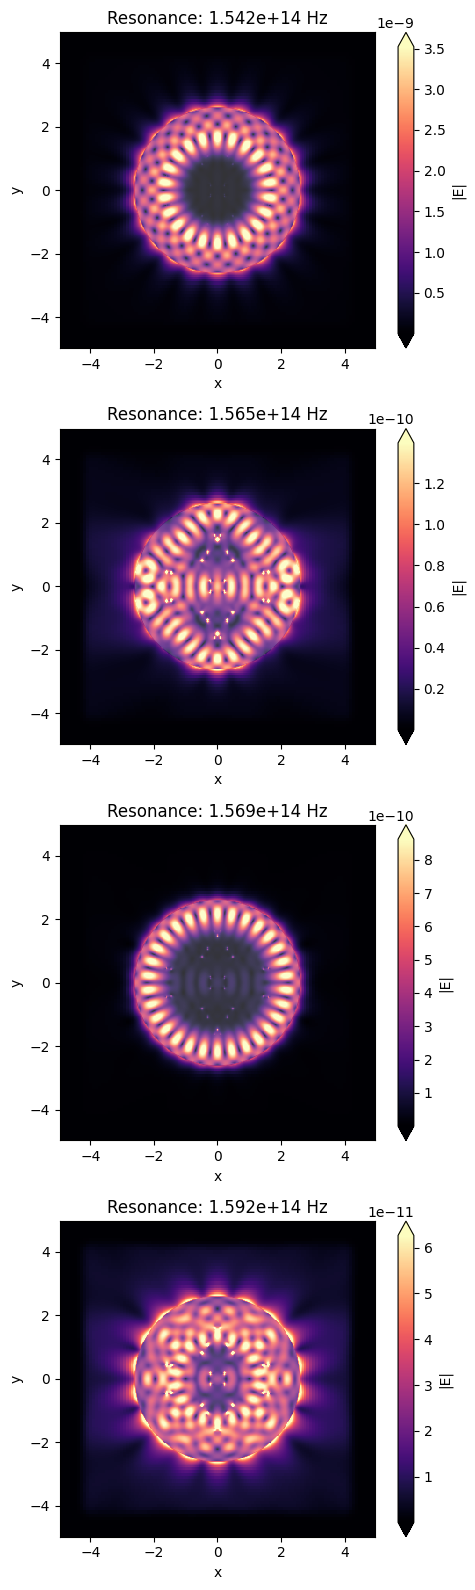

In [13]:
fig, axs = plt.subplots(n_modes, 1, tight_layout=True, figsize=(5, 4 * n_modes))

for i, (ax, freq) in enumerate(zip(axs, resonance_data["freq"])):
    sim_data_field.plot_field("field_xy_" + str(i), "E", "abs", ax=ax)
    ax.set_title(f"Resonance: {freq:.3e} Hz")
plt.show()